In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Étalonnage de la caméra affine

Nous allons effectuer un étalonnage affine de la caméra en utilisant deux images différentes d'une grille d'étalonnage. Tout d'abord, vous trouverez des correspondances entre les coins des grilles d'étalonnage et les coordonnées de la scène 3D. Ensuite, vous résoudrez les paramètres de la caméra.

Il a été démontré en classe qu'une caméra en perspective peut être modélisée à l'aide d'une matrice $3 × 4$ :
$$\begin{bmatrix}
x\\
y\\
w
\end{bmatrix}=\begin{bmatrix}
 p_{11}&  p_{12}  &  p_{13}  & p_{14} \\
 p_{21}&  p_{22}  &  p_{23}  & p_{24} \\
 p_{31}&  p_{32}  &  p_{33}  & p_{34}
\end{bmatrix}\begin{bmatrix}
X\\
Y\\
Z\\
1
\end{bmatrix}$$

ce qui signifie que l'image au point (X, Y, Z) de la scène a des coordonnées de pixels $(x/w, y/w)$. La matrice $3 × 4$ peut être factorisée en paramètres intrinsèques et extrinsèques.

Une caméra affine est un cas particulier de ce modèle dans lequel les rayons reliant un point de la scène à sa projection sur le plan de l'image sont parallèles. Parmi les exemples de caméras affines, on peut citer la projection orthographique et la projection en perspective faible. Une caméra affine peut être modélisée comme suit :

$$\begin{bmatrix}
x\\
y\\
w
\end{bmatrix}=\begin{bmatrix}
 p_{11}&  p_{12}  &  p_{13}  & p_{14} \\
 p_{21}&  p_{22}  &  p_{23}  & p_{24} \\
 0&  0  & 0  & 1
\end{bmatrix}\begin{bmatrix}
X\\
Y\\
Z\\
1
\end{bmatrix}$$


qui donne la relation entre un point de la scène (X, Y, Z) et son image (x, y). La différence est que la rangée inférieure de la matrice est $[ 0 0 0 1 ]$, ce qui réduit le nombre de paramètres à calibrer. Plus important encore, aucune division n'est nécessaire (la coordonnée homogène est 1), ce qui signifie qu'il s'agit d'un modèle linéaire. Le modèle affine est donc beaucoup plus simple à utiliser sur le plan mathématique - au prix d'une perte de précision. Le modèle affine est utilisé comme approximation du modèle perspectif lorsque la perte de précision peut être tolérée, ou pour réduire le nombre de paramètres modélisés. L'étalonnage d'une caméra affine implique l'estimation des 8 entrées inconnues de la matrice de l'Eq. 2. (Cette matrice peut également être factorisée en valeurs intrinsèques et extrinsèques, mais cela n'entre pas dans le cadre de ce travail). La factorisation est réalisée en demandant à la caméra d'observer un modèle d'étalonnage avec des coins faciles à détecter.

## Scene Coordinate System
Le schéma d'étalonnage utilisé est illustré à la figure 1. Il s'agit d'une grille de carrés de $ 6 × 6 $. Chaque carré mesure $50 mm × 50 mm$. La séparation entre les carrés adjacents est de 30 mm, de sorte que la grille entière mesure $450 mm × 450 mm$. Pour l'étalonnage, des images du motif à deux positions différentes ont été prises. Ces images sont présentées dans la figure 1 et peuvent être téléchargées à partir du site web du cours. Pour la deuxième image, le motif d'étalonnage a été reculé (le long de sa normale) de 150 mm par rapport à la position de repos.



<img src="https://drive.google.com/uc?export=view&id=1x5FKk6bqaSRSgxwq2aEc7NN9g0xGyB5g"
 display="text-align">

L'origine de notre système de coordonnées 3D sera le coin supérieur gauche de la mire d'étalonnage en position de repos. L'axe X va de gauche à droite, parallèlement aux rangées de carrés. L'axe Y va de haut en bas, parallèlement aux colonnes de carrés. Nous travaillerons en unités de millimètres. Tous les coins des carrés de la première position correspondent à $Z = 0$. La deuxième position de la grille d'étalonnage correspond à $Z = 150$. Le coin supérieur gauche de la première image a les coordonnées 3D de la scène (0, 0, 0) et le coin inférieur droit de la deuxième image a les coordonnées 3D de la scène $(450, 450, 150)$. Le système de coordonnées de la scène est indiqué sur la figure 1.

* (a) Étant donné les correspondances pour la grille d'étalonnage, résoudre les paramètres de la caméra à l'aide de l'équation 2. Notez que chaque mesure $(x_i , y_i) ↔ (X_i , Y_i , Z_i)$ produit deux équations linéaires pour les 8 paramètres inconnus de la caméra. Étant donné N mesures de coins, nous avons 2N équations et 8 inconnues. En utilisant les correspondances de coins données comme entrées, complétez la méthode compute camera matrix(). Vous allez construire un système linéaire d'équations et résoudre les paramètres de la caméra pour minimiser l'erreur des moindres carrés. Vous renverrez ensuite la matrice affine $3 × 4$ de la caméra, composée des paramètres calculés. Dans votre rapport écrit, soumettez votre code ainsi que la matrice de la caméra que vous avez calculée.

* (b) Après avoir trouvé la matrice calibrée de la caméra, vous calculerez l'erreur quadratique moyenne entre les N coordonnées des coins de l'image et les N positions calculées correspondantes dans rms error(). Rappelez-vous que

$$RMS_{total}=\sqrt{\sum ((x-x')^2+(y-y')^2)/N}$$
Veuillez soumettre votre code et l'erreur quadratique moyenne pour la matrice de la caméra que vous avez trouvée dans la partie
(a).
* (c) Pourriez-vous calibrer la matrice avec une seule image de damier ? Expliquez brièvement en une ou deux phrases.

In [2]:
# Charger les coordonnées de l'exemple setup.
real_XY = np.load('real_XY.npy')
front_image = np.load('front_image.npy')
back_image = np.load('back_image.npy')

In [3]:
image=cv2.imread('front.png')

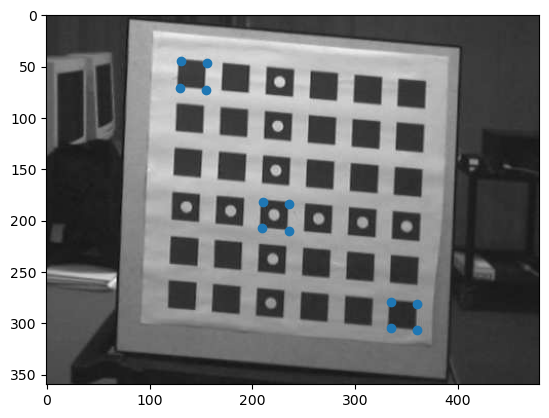

In [4]:
plt.imshow(image)
plt.scatter(front_image[:,0],front_image[:,1])

In [5]:
print(real_XY.shape)
print(front_image.shape)
print(back_image.shape)

(12, 2)
(12, 2)
(12, 2)


In [6]:
img_num1 = front_image.shape[0]
img_num2 = back_image.shape[0]

x = np.vstack((front_image,back_image)).T
x_ones = np.ones((1, x.shape[1]))
x = np.vstack((x, x_ones))

In [7]:
X = np.vstack((real_XY,real_XY)).T

Z = np.zeros((1, X.shape[1]))
Z[:,img_num1:] = 150

X = np.vstack((X, Z))
X_ones = np.ones((1, X.shape[1]))
X = np.vstack((X, X_ones))

In [8]:
X.shape

(4, 24)

In [9]:
A = np.zeros((2 * (img_num1+img_num2), 8))
for i in range(0, A.shape[0], 2):
        A[i, :] = np.hstack((X[:, i//2].T, [0, 0, 0, 0]))
        A[i + 1, :] = np.hstack(([0, 0, 0, 0], X[:, i//2].T))

In [10]:
b = front_image[0].T
for i in range(1, img_num1, 1):
        b = np.hstack((b, front_image[i].T))
for j in range(img_num2):
        b = np.hstack((b, back_image[j].T))
b = np.reshape(b, (2 * (img_num1 + img_num2), 1))

In [11]:
p = np.linalg.inv(A.T.dot(A)).dot(A.T).dot(b)
p = np.reshape(p, (2, -1))
camera_matrix = np.vstack((p, [0, 0, 0, 1]))



In [12]:
print("Matrice de la caméra:\n", camera_matrix)

Matrice de la caméra:
 [[ 5.31276507e-01 -1.80886074e-02  1.20509667e-01  1.29720641e+02]
 [ 4.84975447e-02  5.36366401e-01 -1.02675222e-01  4.43879607e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [13]:
x_pred = camera_matrix.dot(X)

In [14]:
x_pred.shape

(3, 24)

In [15]:
diff_sqr = (x_pred - x) ** 2
diff_sum = np.sum(np.sum(diff_sqr, axis=0))
diff_sum /= (img_num1 + img_num2)
rms_error = np.sqrt(diff_sum)

In [16]:
print("Erreur RMS: ", rms_error)

Erreur RMS:  0.9938304832798395


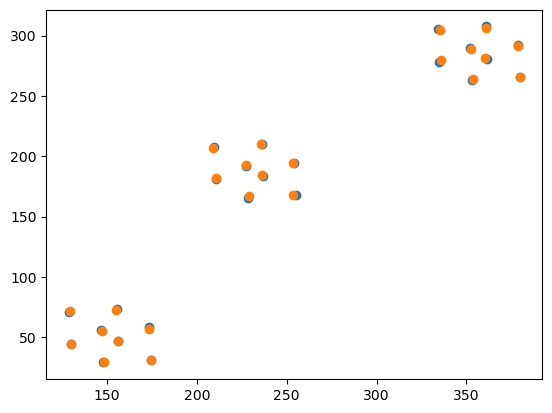

In [18]:
plt.scatter(x_pred[0,:],x_pred[1,:])
plt.scatter(x[0,:],x[1,:])